<a name="cell-TOC-GenMod"></a>

12. [Generative Modeling](#cell-GenMod)
    1. [Neural Networks Loss Function and the Likelihood Principle](#cell-GenMod-lik)
        1. [Masked Autoencoder Density Estimation (MADE)](#cell-GenMod-MADE)
        2. [Kullback-Leibler (KL) divergence](#cell-GenMod-KL)
    2. [Variational Inference](#cell-GenMod-VI)
        1. [EM algorithm (general proof: ELBO is a special case)](#cell-GenMod-EM)
        2. [Variational Autoencoder](#cell-GenMod-VAE)
        3. [Bayes by Backprop](#cell-GenMod-BBB)
    3. [Transformation (Bijections) of Variables](#cell-MCint-sampling-bijections)
        1. [Normalizing Flows](#cell-MCint-sampling-normalizingflows)
        2. [Masked Autoregressive Flows (MAFs)](#cell-MCint-sampling-MAFs)
        4. [Inverse Autoregressive Flows (IAFs)](#cell-MCint-sampling-IAFs)
        5. [Real NVP: Easy Jacobian with Affine Transformations](#cell-MCint-sampling-RNVP)
    4. [Simulated Annealing](#cell-MCint-sampling-RNVP)
 
<!--    1. [Copulas: Conditional Distributions via Differentiation](#cell-MCint-sampling-copulas) -->


<a name="cell-GenMod-lik"></a>

### 12.A Neural Network Loss Functions and the Likelihood Principle ([Return to TOC](#cell-TOC-GenMod))

---

Traditional ***neural networks*** specify $\hat y_i = f_{\theta}(x_i)$ for ***classification*** or ***regression*** and then optimize 

$$\text{the objective function }\quad \min_\theta \sum_{i=1}^n L(y,\hat y) \quad \text{ for loss function } L$$

often respectively chosen as ***cross-entropy loss*** or ***squared loss*** based on the ***likelihood principle*** 

\begin{align*}L(y,\hat y=p) ={}& - \sum_{i=1}^n y_i\log(p_i) + (1-y_i)(1-\log(p_i)) \color{gray}{= -\sum_{i=1}^n y_{ik} \log(p_{ik})} \\ \propto{}& - \log \text{Bernoulli}(y_i | p_i= \hat y_i = f_{\theta}(x_i)) \quad\quad \color{gray}{\text{multinomial generalization}}\\
\text{or } \quad L(y,\hat y) ={}& \frac{1}{2} \sum_{i=1}^n (y_i -\hat y_i)^2 \propto \log N (y_i | \hat y_i=f_{\theta}(x_i), \sigma=1)
\end{align*}

generally suggesting a distributional evaluation based ***loss*** $L(y,\hat y) = \log p(y_i|\hat y_i = f_{\theta}(x_i))$ 

<a name="cell-GenMod-MADE"></a>

### 12.A.a Masked Autoencoder Density Estimation (MADE) ([Return to TOC](#cell-TOC-GenMod))

---

Parameterizing ***conditional distributions*** with an ***autoregressive*** dependence structure

$$p_{X_k|X_{k-1}, \cdots, X_1}(x_k|x_1,\cdots,x_{k-1}) = p_{\theta_k(x_1,\cdots,x_{k-1})}(x_k)$$ 

for parametric distribution family $p_{\theta_k}$ gives a ***chain rule*** reconstructed ***joint distribution*** 

$$\begin{align*}
p(x_1, \cdots, x_k) = {} & \prod_{j=1}^k p_{X_j|X_{j-1},\cdots,X_1}(x_j|x_{j-1},\cdots,x_1) = \prod_{j=1}^k p_{\theta_j(x_1,\cdots,x_{j-1})}(x_j)
\end{align*}$$

In ***Masked Autoencoder Distribution Estmation (MADE)*** the function $\theta_k(x_1,\cdots,x_{k-1})$ parameterizing the parametric probability distribution $p_{\theta_k}$ is a ***neural network*** $\theta_k$ where

- ***masked*** refers to the ***autoregressive*** usage of $X_1, \cdots, X_{j-1}$ relative to $X_j$
- and ***autoencoder*** refers to the fact that $X_1, \cdots, X_k$ is both the input which defines $p_{\theta(x_1,\cdots,x_{k})}(x_1, \cdots, x_k)$ as well as the output on which it is evaluated
<!-- (even though the structure of the input driving the output is still ***autoregressively conditional***) --> 

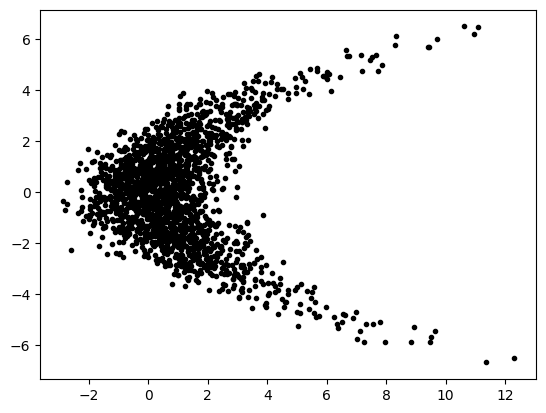

In [9]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork
import numpy as np; import matplotlib.pyplot as plt; n = 2000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
# note (1) that it's most informative to condition as p(x2)p(x1|x2)
# note (2) that x1 is more than a shift-scale transformation of x1
data = np.stack([x1,x2], axis=-1)
plt.plot(x1,x2,'k.');

(None, 2)


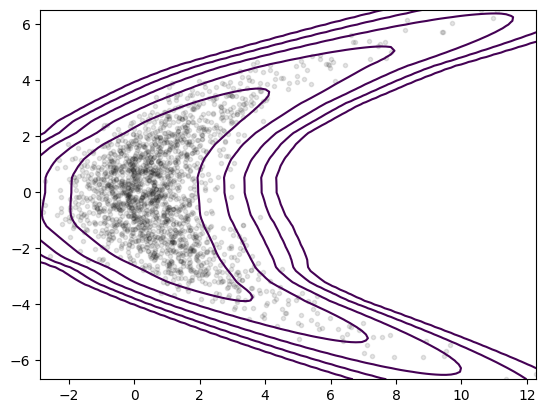

In [10]:
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork
ARN = tfb.AutoregressiveNetwork(params=2, hidden_units=[25, 25], 
                                activation='relu', input_order='right-to-left')
# Input: (not yet specified); but, it will be 
#        [batch, dimension_of_an_observation] = [n,q]
# Output: count of real-valued autoregressive outputs for each dimension_of_an_observation
#        [n,params,q] = [n,2,q] which can be used as mu_j and log(sigma_j)
#        defining autoregressive conditional distributions p(x_j|x_j-1,...,x_0) = N(mu_j,exp(log_sigma_j)) 
#        i.e., jth entry in params axis depends on inputs j-1,...,0
# Network: (will enforce the Autoregressive property with Masking)
# `hidden_units=[latent_variables, latent_outputs] = [10, 10]` 
# [n, q] x [q, latent_variables] x [latent_variables, transformed_variables] x 
# [transformed_variables, params, q] = [n, params, q]
#  
# note (1) that `input_order='right-to-left'` gets the natural conditioning direction correct
# note (2) that `activation='relu'` allows the neural network to use nonlinear transformations
# e.g., a "v" shape can be made by relu(x2) for x2>0 and relu(-x2) for x2<0; and,
# the "piecewise" feel below is from using differently offset and scaled relu functions 

x_ = tfkl.Input(shape=(2,), dtype=tf.float32) # [n,q]
# In tensorflow `shape=(2,)` specifies the dimension of a single observation (q)
# while `batch` is assumed as the first dimension (`None` will be `n`)
print(x_.shape)
# https://www.tensorflow.org/probability/api_docs/python/tfp/layers/IndependentNormal
MADE = tfk.Sequential([x_, ARN, tfkl.Flatten(data_format='channels_first'), 
                       tfpl.IndependentNormal(2)])
# `tfpl.IndependentNormal(2)` inputs are mu_1, mu_2, log_sigma_1, log_sigma_2 
# but `ARN` output is [[mu_1,log_sigma_1],[mu_2,log_sigma_2]] so
# `data_format='channels_first'` reads the mu's first and then the log_sigma's
# i.e., [i,k,j] iterates in i,j,k order over [n, params, q] and j=0 is mu's

# https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html
negloglik = lambda x, p_x: -p_x.log_prob(x)
MADE.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
MADE.fit(data, data, epochs=20, verbose=False)

g = 100
g1,g2 = np.meshgrid(np.linspace(x1.min(), x1.max(), g), 
                  np.linspace(x2.min(), x2.max(), g))
grid = np.stack([g1.flatten(), g2.flatten()], axis=-1)
plt.plot(x1, x2, 'k.', alpha=0.1)
plt.contour(g1, g2, np.exp(MADE(grid).log_prob(grid).numpy().reshape(g,g)), 
            levels=np.logspace(-5,2,10))

<a name="cell-GenMod-KL"></a>

## 12.A.b Kullback-Leibler (KL) divergence ([Return to TOC](#cell-TOC-GenMod)) 

---

***Kullback-Leibler (KL) divergence*** measures a "distance between distributions"

$$KL[\, q(\theta) \, || \, p(\theta) \,]  = \int \frac{q(\theta)}{p(\theta)} q(\theta) d \theta \quad \text{which is nonnegative}$$

but ***KL divergence*** <u>does not satisfy</u> the ***triangle equality***  and so is not a ***metric***

> $KL[\, q(\theta) \, || \, p(\theta) \,] \not \leq KL[\, q(\theta) \, || \, r(\theta) \,] + KL[\, r(\theta) \, || \, p(\theta) \,]$<!--; rather,  as seen below $\scriptsize  KL[\, q(\theta) \, || \,  p(\theta) \, ] = KL[\, q(\theta) \, || \,  p(\theta|y) \, ] + E_{q(\theta)}[ \log p(y|\theta)/p(y) ]$ -->

***KL divergence*** provides an objective function for approximate Bayesian inference

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$

where the posterior $p(\theta|y)$ is approximated with $q(\theta)$ which is often $q_\phi(\theta)$ a ***multivariate normal distribution*** with ***variational parameters*** $\phi = \boldsymbol \mu, \boldsymbol \Sigma$ a ***location*** and constrained ***covariance matrix***


<a name="cell-GenMod-VI"></a>

## 12.B Variational Inference ([Return to TOC](#cell-TOC-GenMod)) 

---

<!-- furher discussion/interpretation about this https://github.com/pointOfive/Summer_2022_STA496H1/blob/main/files/DenseVariational.ipynb -->

Approximate Bayesian Analysis indirectly optimizes the posterior approximation

$$
\begin{align*}
\underset{\text{constant}}{\overset{\text{a fixed}}{\log p(y)}} = {} & \int \log p(y) q(\theta) d\theta \\
= {} & \int \log \frac{p(\theta,y)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta = \int \log \frac{p(y|\theta)p(\theta)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \underbrace{\int \log p(y|\theta) q(\theta) d\theta }_{E_{q(\theta)}[\log p(y|\theta)]} + \underline{KL[\, q(\theta) \, || \, p(\theta|y) \,]}  - KL[\, q(\theta) \, || \, p(\theta) \,] 
\end{align*}
$$
by instead maximizing $\quad \text{ELBO}(q)= \overbrace{E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}^{\text{the Evidence Lower BOund}} \leq \log p(y) $

by finding $q(\theta)$ which unsurprisingly balances a contribution from the ***prior*** and the ***likelihood***

## 12.B Variational Inference 

---

Approximation Bayesian posterior inference is thus equivalently

$$ \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,] \quad \text{ or } \quad  \max_\phi \text{ELBO}(q_\phi) \quad \text{ or } \quad \min_\phi -\text{ELBO}(q_\phi)$$

where $\text{ELBO}(q_\phi)$ equivalence may be derived directly from the desired Bayesian optimization

$$
\begin{align*}
KL[\, q_\phi(\theta) \, || \,  p(\theta|y) \, ] = {} & \int \log \frac{q(\theta)}{p(\theta|y)}q(\theta)d\theta\\
= {} & \int \log \frac{q(\theta)p(y)}{p(y|\theta)p(\theta)}q(\theta) d\theta\\
= {} & \underset{\text{fixed}}{\log p(y)} + \int \log \frac{q(\theta)}{p(\theta)}q(\theta) d\theta - \int \log p(y|\theta) q(\theta) d\theta \\
= {} & \underset{\text{constant}}{\log p(y)} + \underbrace{KL[\, q(\theta) \, || \,  p(\theta) \, ] - E_{q_\phi(\theta)}[ \log p(y|\theta)]}_{-\text{ELBO}(q_\phi)} \\
\end{align*}
$$

## 12.B Variational Inference 

---

Approximation Bayesian posterior inference is thus equivalently

$$ \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,] \quad \text{ or } \quad  \max_\phi \text{ELBO}(q_\phi) \quad \text{ or } \quad \min_\phi -\text{ELBO}(q_\phi)$$

and $\text{ELBO}(q_\phi)$ may be derived with Jensen's inequality with  expectations and no KL-terms

$$ 
\begin{align*}
\log p(y) = {} & \log \int p(y,\theta) \frac{q(\theta)}{q(\theta)} d\theta &={}&  \log \int  p(y|\theta)\frac{p(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \log E_{q(\theta)}\left[ p(y,\theta)\frac{1}{q(\theta)} \right]  &={}&  \log E_{q(\theta)}\left[ p(y|\theta)\frac{p(\theta)}{q(\theta)} \right]\\
\geq {} & E_{q(\theta)}\left[ \log p(y,\theta)\frac{1}{q(\theta)} \right] &={} & E_{q(\theta)}\left[ \log p(y|\theta)\frac{p(\theta)}{q(\theta)} \right] \\
= {} & \underbrace{E_{q_\phi(\theta)}[ \log p(y,\theta) - \log q(\theta)]}_{\text{ELBO}(q_\phi) \text{ (now use EM algorithm...)} } &={} & \underbrace{E_{q_\phi(\theta)}[ \log p(y|\theta)] - KL[\, q_\phi(\theta) \, || \, p(\theta) \,]}_{\text{ELBO}(q_\phi)}
\end{align*}
$$

<a name="cell-GenMod-EM"></a>

### 12.B.a EM algorithm (general proof: ELBO is a special case) ([Return to TOC](#cell-TOC-GenMod)) 

\begin{align*}
\log p(y \mid {\phi}) = {}& \log p(y \mid {\phi}) \color{navy}{+ \log p(\theta  \mid y, {\phi}) - \log p(\theta  \mid y, {\phi})}\\
={}&\color{purple}{\log p(y ,\theta \mid {\phi})} -\log p(\theta \mid y ,{\phi}) \quad \color{green}{\text{ now integrate out } \theta} \\
={}&\underbrace{\color{green}{E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log  p(y ,\theta \mid {\phi})]}_{\Large Q({\phi} \mid {\phi}^{(t)})} - \underbrace{\color{green}{E_{p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log p(\theta \mid y ,{\phi})]}_{\Large H({\phi}\mid {\phi}^{(t)})}\\
\overset{\phantom{a}}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})}
={}& Q({\phi} \mid {\phi}^{(t)})-H({\phi}\mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})+H({\phi}^{(t)}\mid {\phi}^{(t)})\\
{}& \underset{\phantom{a}}{\overset{\phantom{a}}{\text{but since }}} H({\phi}^{(t)}\mid {\phi}^{(t)}) \geq H({\phi}\mid {\phi}^{(t)})\\
\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})
\geq{}& Q({\phi} \mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})\\
{} & \overset{\phantom{a}}{\text{so if }} \quad Q({\phi}^{(t+1)}\mid \phi^{(t)}) > Q({\phi}^{(t)}\mid {\phi}^{(t)}) \\
{} & \text{then } \quad \log p(y \mid {\phi}^{(t+1)}) > \log p(y \mid {\phi}^{(t)})\\
{}&  \color{gray}{\text{where }} \;\; \color{gray}{Q({\phi}^{(t+1)}\mid \phi^{(t+1)}) = \log E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}[p(y ,\theta \mid {\phi}^{(t+1)})]}
\end{align*}



<a name="cell-GenMod-VAE"></a>
## 12.B.b Variational Autoencoders ("Nonlinear PCA") ([Return to TOC](#cell-TOC-GenMod))
---

- Let $q_\phi$ be some function which transforms $x \in I\!\!R^n$ to $v \in I\!\!R^m$ for $m<n$ 
- while $g_\gamma$ is some function which transforms that $v \in I\!\!R^m$ back to $x' \in I\!\!R^n$ 

***Autoencoders*** seek to define $q_\phi$ and $g_\gamma$ such that $g_\gamma(q_\phi(x)) \approx x$ via $\displaystyle \min_{q_\phi, g_\gamma} ||x - g_\gamma(q_\phi(x)) ||_2^2$

***Variational autoencoders*** approximate the "posterior" ***conditional distribution*** $p(v|x)$ with ***variational distribution*** $q_{\phi(x)}(v)$ while taking $p(x|v) = g_{\gamma(v)}(x)$ based on ***variational inference***

$$ \min_\phi KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi,\gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v)\;=}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$$

- Note though this is not "Bayesian" posterior inference on the parameters $\phi$ and $\gamma$



## 12.B.b Variational Autoencoders ("Nonlinear PCA")
---

$\min_q KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi, \gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v) \; =}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$ <!--is an objective function which can be realized as-->
- Use ***neural networks*** $\phi_\mu(x)$, ${\phi_\sigma}(x)$, and $\gamma(v)$ parameterizing distributions $q$ and $g$

    - $q_{\phi(x)}(v) = N(\mu={\phi_\mu}(x), \mu={\phi_\sigma}(x))\quad$ and $\quad p(v) = N(\mu_0,\sigma_0)$ 
        - so the ***KL*** term has a known analytical form for normal distributions    

- Use a ***reparameterization*** trick $v = {\phi_\mu}(x) + \phi_\sigma(x)\epsilon = \mu_x + \sigma_x \epsilon, \epsilon \sim N(0,1)\;$ so 
$$\textstyle \frac{\partial}{\partial \phi} E_{q_{\phi(x)}\!(v)}[ \log g_{\gamma(v)}(x)] =  E_{\epsilon}[ \frac{\partial}{\partial \phi} \log g_{\gamma(v)}(x)] = E_{\epsilon}[\underset{\text{Total derivative}}{\underline{\frac{\partial}{\partial v} \overset{\log}{g_{\gamma(v)}}(x) \frac{\partial v}{\partial \phi} + \frac{\partial}{\partial \phi} \overset{\log}{g_{\gamma(v)}}(x) }}]$$
- Use a single sample $v' \sim q_{\phi(x)}$ Monte Carlo estimation of $\frac{\partial}{\partial \gamma} E_{\epsilon}[\cdots]$
$$\textstyle  = E_{\epsilon}[\frac{\partial}{\partial \gamma} \cdots] = \frac{\partial}{\partial \gamma} \overset{\log}{g_{\gamma(v')}}(x) \; \text{ and } \;  \textstyle \frac{\partial}{\partial \phi} \big(E_{q_{\phi(x)}\!(v)}[ \overset{\log}{g_{\gamma(v)}}(x)] - KL\left[ q_{\phi(x)}(v') \,||\, p(v') \right] \big)$$
to provide estimates for ***gradient descent*** on ***neural network*** parameters $\phi$ and $\gamma$

<a name="cell-GenMod-BBB"></a>
## 12.B.c Stochastic NN Layers / Bayes by Backprop ([Return to TOC](#cell-TOC-GenMod))

The classic $\rho(x^Tw + b)$ layer for input $x$ (hereafter omitted for brevity) is a standard part of ***neural network*** $p(y|w)$ and admits 
***variational inference*** appoximation of $p(w|y)$  with $q_\theta(w)$ 


\begin{align*}
\min_\theta KL\left[ q_\theta(w) \,||\, p(w|y) \right] \equiv {}& \max_{\theta} E_{q_\theta(w)}\big[ \underbrace{\log \big(p(y|w) \times \overbrace{p(w) \div q_{\theta}(w)}^{\text{KL after expectation}}}_{f_{\theta}(w,y)} \big)\big]\\
= {} & \max_{\theta=\mu,\sigma} E_{\epsilon}[\underbrace{\overbrace{\log p(w = \mu + \epsilon \sigma,y)}^{\log p(y|w) + c} - \log q_\theta(w = \mu + \epsilon \sigma)}_{\text{with the reparameterization trick $w_i = \mu_i + \epsilon_i \sigma_i$ with $\epsilon_i \sim N(0,1)$}}] 
\end{align*}

$\frac{\partial}{\partial \theta} E_{\epsilon}[\cdots] = E_{\epsilon}[\frac{\partial}{\partial \theta} f(w,y)]$ and (***total derivative***) $\frac{\partial}{\partial \theta} f(w,y) = \frac{\partial}{\partial w}  f(w,y) \frac{\partial w}{\partial \theta} + \frac{\partial}{\partial \theta} f(w,y)$

which is estimated with a single sample Monte Carlo draw that optimizes $\underset{= N(\mu,\sigma)}{q_\theta(w)} \approx p(w|y)$ 

<a name="cell-MCint-sampling-bijections"></a>

## 12 Transformation (Bijections) of Variables ([Return to TOC](#cell-TOC-GenMod))

---

For random variables $X$ and $Z$

$${X}=g({Z}) \quad \text{with} \quad {Z}\sim \tilde p_{Z}({Z}={z}) \quad \Longrightarrow \quad {X}\sim p_{X}({X}={x})$$

through the ***change of variables*** formula
$$\begin{align*}
p_{X}({x}) = {} & \tilde p_{Z}\big(\overbrace{g^{-1}({x})}^{{z}}\big) \left| \det Jg^{-1}\left({x}\right) \right| = \tilde p_{Z}\big(g^{-1}({x})\big) \left| \; \det \left[ \begin{array}{ccc} \frac{\partial g^{-1}_1({x})}{\partial x_1} &\cdots &  \frac{\partial g^{-1}_1({x})}{\partial x_m} \\ \vdots & \ddots & \vdots \\ \frac{\partial g^{-1}_m({x})}{\partial x_1} &\cdots &  \frac{\partial g^{-1}_m({x})}{\partial x_m}\end{array} \right] \quad \right|\\
= {} & \tilde p_{Z}\big(\overbrace{g^{-1}({x})}^{{z}}\big) \left| \det J g\left({z}\right) \right|^{-1} = \tilde p_{Z}\big(g^{-1}({x})\big) \;\! \left| \; \det \left[ \begin{array}{ccc} \frac{\partial g_1({z})}{\partial z_1} &\cdots &  \frac{\partial g_1({z})}{\partial z_m} \\ \vdots & \ddots & \vdots \\ \frac{\partial g_m({z})}{\partial z_1} &\cdots &  \frac{\partial g_m({z})}{\partial z_m}\end{array} \right] \quad \right|^{-1}
\end{align*}$$


<a name="cell-MCint-sampling-bijections-1"></a>

## 12.C Transformation (Bijections) of Variables 

---

For random variables $X$ and $Z$

$${X}=g({Z}) \quad \text{with} \quad {Z}\sim \tilde p_{Z}({Z}={z}) \quad \Longrightarrow \quad {X}\sim p_{X}({X}={x})$$

through the ***change of variables*** formula
$$\begin{align*}
p_{X}({x}) = {} & \tilde p_{Z}\big(\overbrace{g^{-1}({x})}^{{z}}\big) \left| \det Jg^{-1}\left({x}\right) \right| = \tilde p_{Z}\big(\overbrace{g^{-1}({x})}^{{z}}\big) \left| \det J g\left({z}\right) \right|^{-1} \quad\quad\quad\quad\quad\quad\quad
\end{align*}$$

which immediately shows that 
1. $g^{-1}({x})$ must be monotonically increasing or decreasing <font style='color:gray'>so $\tilde p\big(g^{-1}({x})\big)$ is unambiguous</font>
2. the dimensions $\dim({X})=\dim({Z})=m$ <font style='color:gray'>otherwise the ***determinant*** is not defined</font>
3. the function $g({z})$ and hence $g^{-1}({x})$ must be differentiable <font style='color:gray'>so the ***Jacobian*** is defined</font>

In modern (neural network) parlance this is called a ***bijection*** 



<a name="cell-MCint-sampling-normalizingflows"></a>

## 12.C.a Normalizing Flows ([Return to TOC](#cell-TOC-GenMod))

---

In modern (neural network) parlance a sequence of ***chained bijections*** are called ***flows***

> The sequence of ***transformation*** or ***change of variables*** is a ***flow***...

$$\begin{align*}
X^{(k)} = {} & g^{(k)}(X^{(k-1)}) \\
\text{with } \; X^{(k)} \sim {} & p_{X^{(k-1)}}\big({g^{(k)}}^{-1}\!\!\left(X^{(k)}\right)\big) \left| \det J{{g^{(k)}}^{-1}}\left(X^{(k)}\right) \right| \quad \color{gray}{\text{ or } \; \left| \det J{{g^{(k)}}}\left(X^{(k-1)}\right) \right|^{-1}} \\
\text{so } \; X^{(k)} \sim {} &  \tilde p_{X^{(0)}}\big({g^{(1)}}^{-1}\!\!\left(X^{(1)}\right)\big) \prod_{j=1}^k \left| \det J{{g^{(j)}}^{-1}}\left(X^{(j)}\right) \right| \;\, 
\color{gray}{\text{ or } \; \left| \det J{{g^{(j)}}}\left(X^{(j-1)}\right) \right|^{-1}}
\end{align*}$$

<!-- where $ p_{X^{(k-1)}}\big(X^{(k-1)}\big)$ is either known exactly or recursively defined as specified above so that -->

$X^{(0)} \sim \tilde p_{X^{(0)}}(X^{(0)})$ may be any distribution, but choosing to be $X^{(0)} \sim N(\mathbf{0},\mathbf{I})$ is termed a ***normalizing flow*** since the inverse transformations *normalize* 

$$X^{(0)} = {g^{(k)}}^{-1} \circ {g^{(k-1)}}^{-1} \circ \cdots \circ {g^{(2)}}^{-1} \circ {g^{(1)}}^{-1}( X^{(k)}) \quad \text{ so that } \quad X^{(0)} \sim N(\mathbf{0},\mathbf{I})$$

<a name="cell-MCint-sampling-normalizingflows-1"></a>

## 12.C.a Normalizing Flows 

---

***Normalizing flows*** are often defined in terms of the transformation of an arbitrary distribution  

$$X^{(0)} = {g^{(0)}} \circ {g^{(1)}} \circ \cdots \circ {g^{(k-1)}} \circ {g^{(k)}}( X^{(k)}) \quad \text{ so that } \quad X^{(0)} \sim N(\mathbf{0},\mathbf{I})$$

with ***forward*** and ***inverse transformation*** notations being a matter of preference

<!-- ***Flows*** exist because -->
- ***Jacobian*** computations $\left| \det Jf^{-1}\left(X\right)\right| = \left|\det Jf(\left(Z\right)\right|^{-1}$ for a single sufficiently rich transformation $f$ of $X^{(0)}\sim \tilde p_X^{(0)}$ into arbitrary $X \sim p_X$ are generally prohibitive... 
- but a sequence of simpler transformations $g^{(k)}$ with "inexpensive" ***Jacobian*** computations can be chained together to create a sufficiently rich $f = g{(k)}\circ \cdots \circ g{(0)}(X^{(0)})$ which is able to transform a distribution $X^{(0)}\sim \tilde p_X^{(0)}$ into arbitrary $X \sim p_X$

A ***neural network*** theoretically models any function (***transformation***) but the standard ***nonlinear activation function*** on ***affine transformations*** $g^{(k)}\! \left(X^{(k)}\right) = \rho \odot (A_k X^{(k)} + b_k)$ will (ignoring $\rho$) requires an arbitrary (generally intractable) ***Jacobian*** calculation $\det J_{A_k X^{(k)} + b_k}=|\det A_k|^{-1}$


<a name="cell-MCint-sampling-MAFs"></a>

## 12.C.b Masked Autoregressive Flows (MAFs) ([Return to TOC](#cell-TOC-GenMod))

---

A ***masked autoregressive flow (MAF)*** simplifies ***Jacobian*** computations by parameterizing<br>***scale-shift transformations*** of $X_j^{(t-1)}$ into $X_j^{(t)}$ by $X^{(t)}$ itself; except, by only using previously transformed $X_{1:(j-1)}^{(t)}$ through a ***full conditional autoregressive dependency structure*** (like ***MADE***) 

$$\begin{align*}
X^{(t)}_0 = {} &  \mu^t_{0} +  \sigma^t_{0} \cdot X^{(t-1)}_0\\
X^{(t)}_j = {} & \underset{\text{nonlinear functions, e.g., NNs}}{\underbrace{ \mu^{(t)}_{j}(X^{(t)}_{0:j-1}) +  \sigma^{(t)}_{j}(X^{(t)}_{0:j-1})}_{\text{$ \mu^{(t)}$ and $ \sigma^{(t)}$ are autoregressive}}} \cdot  X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

which may be expressed (without notating the ***autoregressive dependency structure***) as 

$$\begin{align*}
X^{(t)} = g^{(t)}(X^{(t-1)}) = {} & \boldsymbol \mu^{(t)}_{X^{(t)}} + (\boldsymbol \sigma^{(t)}_{X^{(t)}}) \odot X^{(t-1)} \\
X^{(t-1)} = {g^{(t)}}^{-1}(X^{(t)}) = {} &  
\left(X^{(t)} - \boldsymbol \mu_{X^{(t)}}^{(t)}\right) \big/ (\boldsymbol \sigma_{X^{(t)}}^{(t)})
\end{align*}$$


<a name="cell-MCint-sampling-MAFs-1"></a>

## 12.C.b Masked Autoregressive Flows (MAFs) 

---

Due to the ***autoregressive dependency structure***
$[\mu^{(t)}_{X^{(t)}}]_j$ and $[\boldsymbol \sigma^{(t)}_{X^{(t)}}]_j$
only depend on $X_{1:(j-1)}^{(t)}$ which only depend on $X_{1:(j-1)}^{(t-1)}$; so, $X_j^{(t)}$ only depends on $X_j^{(t-1)}$ through the ***scale transformation***

$$\begin{align*}
{} & \left| \det J{{g^{(t)}}^{-1}}(X^{(t)}) \right| = \left| \det J{{g^{(t)}}}(X^{(t-1)}) \right|^{-1} = 
 \left | \; \det \left[ \begin{array}{ccc}
\frac{\partial X^{(t)}_0}{\partial X^{(t-1)}_0} &
\cdots & \frac{\partial X^{(t)}_0}{\partial X^{(t-1)}_m} \\
\vdots & \ddots & \vdots \\
\frac{\partial X^{(t)}_m}{\partial X^{(t-1)}_0} &
\cdots & \frac{\partial X^{(t)}_m}{\partial X^{(t-1)}_m} 
 \end{array} \right] \; \right |^{-1} \\
= {} & \scriptsize \left | \; \det \left[ \begin{array}{ccc}
\sigma_0^{(t)} &  & 0 \\
 & \ddots \quad\quad\quad \;\;& \\
 &  \sigma_j^{(t)}(X_{0:(j-1)}^{(t-1)}) &\\
 &  \quad\quad\quad\quad \ddots & \\
0 & & \sigma_m^{(t)}(X_{0:(m-1)}^{(t-1)}) 
 \end{array} \right] \;\right |^{-1} \normalsize \!\!\! = 
 \left |\det \text{diag}(\boldsymbol \sigma^{(t)}_{X^{(t)}}) \right|^{-1} \!\!\!\! =  \left |\prod_{j=1}^m  \text{diag}(\boldsymbol \sigma^{(t)}_{X^{(t)}})_{jj} \right|^{-1}
\end{align*}$$



<a name="cell-MCint-sampling-MAFs-1"></a>

## 12.C.b Masked Autoregressive Flows (MAFs) 

---

$$\begin{align*}
X^{(k)} \sim {} & \tilde p_{X^{(0)}}\big({g^{(1)}}^{-1}\!\!\left(X^{(1)}\right)\big) \prod_{j=1}^k \left| \det J{{g^{(j)}}^{-1}}\left(X^{(j)}\right) \right| \; \color{gray}{\text{ or } \; \left| \det J_{{g^{(j)}}(\dot{X^{(j-1)}})}\!\left(X^{(j-1)}\right) \right|^{-1}}\\
\Longrightarrow {} & \log p_{X^{(k)}}(x^{(k)}) = \log p_{X^{(0)}}(x^{(0)}) - \sum_{t=1}^k \log \left |\prod_{j=1}^m  \text{diag}(\boldsymbol \sigma^{(t)}_{x^{(t)}})_{jj} \right| 
\end{align*}$$

which is readily computable

- ***masked autoregressive*** refers to enforcing the way inputs are utilied 
  - $\boldsymbol \mu^{(t)}_{X^{(t)}}$ and $\boldsymbol \sigma^{(t)}_{X^{(t)}}$ are *neural networks* with outputs $\boldsymbol \mu^{(t)}_j(X_{0:(j-1)}^{(t)})$ which are only dependent on inputs $j' < j$ by cutting, i.e. "masking" neural network connections 
- and ***flow*** refers to potentially using a seqeunce of ***masked autoregressive bijections***


(None, 2)


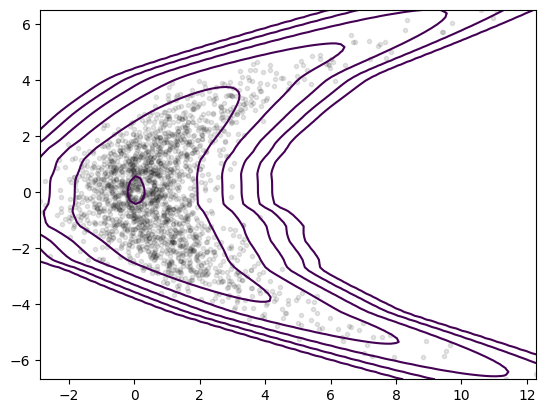

In [11]:
# Rather than parameterizing conditional distributions with 
ARN = tfb.AutoregressiveNetwork(params=2, hidden_units=[512, 512], 
                                activation='relu', input_order='right-to-left')
# this can (equivalently) define a shift-scale transformation 
# of Z_j\sim N(0,1), i.e., Z_j*exp(log_sigma_j))+mu_j for an MAF
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow
# https://arxiv.org/abs/1502.03509 # 2015 MADE: masked autoencoder for distribution estimation
# https://arxiv.org/abs/1705.07057 # 2017 masked autoregressive flow for density estimation

# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/TransformedDistribution
p_X = tfd.TransformedDistribution(
    # `tfd.TransformedDistribution` models x the observed data
    # by p(x) = bijector(p(z)) where `bijector` is learned to transform p(z)
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]), 
    # `distribution` is p(z); but, this need not be a normal distribution
    bijector=tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=ARN))
    # `tfb.MaskedAutoregressiveFlow` defines forward, inverse, and jacobian 
    # of an MAF (i.e., univariate transforms of autoregressive conditionals) 
    # for any `bijector_fn`; but, here we specify that to be a shift-scale
    # transformation with the convenience `shift_and_log_scale_fn` argument   
    # which accepts ARN outputs as inputs to define the shift-scale transform
    
x_ = tfkl.Input(shape=(2,), dtype=tf.float32) # data
print(x_.shape)
log_prob_ = p_X.log_prob(x_) # log p(x) determined by 
# 1. MAF transforming the data to the base distribution p(z)
# 2. computing p(MAF(z)) and all necessary jacobian product corrections
# However, the MAF transform is the shift-scale ARN, which will be an 
# autoregressive neural netwok with input x 
# how to use x autoregressively to transform x into z
MAF = tfk.Model(x_, log_prob_)
# input: x_ is the data
# output: log_prob_ is a function of input x_ so when x_ enters `tfk.Model`
#         it is passed to log_prob_ which calculates based on ARN which has free
#         neural network parameters that may be changed to make improve log_prob_

MAF.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
            loss=lambda x, log_prob: -log_prob) # our target log(p(x)=1) is 0
MAF.fit(x=data, y=np.zeros((n, 0), dtype=np.float32),
        batch_size=256, epochs=50, steps_per_epoch=8,  # Usually `n // batch_size`.
        shuffle=True, verbose=False)

plt.plot(x1, x2, 'k.', alpha=0.1)
plt.contour(g1, g2, p_X.prob(grid).numpy().reshape(g,g), 
            levels=np.logspace(-5,2,10))

<a name="cell-MCint-sampling-IAFs"></a>

## 12.C.d Inverse Autoregressive Flows (IAFs) ([Return to TOC](#cell-TOC-GenMod))

---

Computing $p_{X^{(k)}}(x^{(k)})$ with ***MAF*** requires the ***Jacobian*** products and $p_{X^{(0)}}(x^{(0)})$ and hence 

$$x^{(0)} = {g^{(0)}}^{-1} \circ {g^{(1)}}^{-1} \circ \cdots \circ {g^{(k-1)}}^{-1} \circ {g^{(k)}}^{-1}( x^{(k)})$$ 

but $x^{(t-1)}_j = {g^{(t)}_j}^{-1}(x^{(t)}) = \frac{x^{(t)}_j - \mu^{(t)}_{j}(x^{(t)}_{0:j-1})}{\sigma^{(t)}_{j}(x^{(t)}_{0:j-1})}$ can be computed <u>in parallel</u> for each $j=1,\cdots, m$

so elements of $x^{(t-1)} = {g^{(t)}}^{-1}(x^{(t)}) =  
\left(x^{(t)} - \boldsymbol \mu_{x^{(t)}}^{(t)}\right) \big/ (\boldsymbol \sigma_{x^{(t)}}^{(t)})$ computations are <u>parallelizable</u>

But this was not the case <font style='color:purple'>(intentionally by construction)</font> for the forward transformations 
$X^{(t)} = g^{(t)}(X^{(t-1)}) = \boldsymbol \mu^{(t)}_{X^{(t)}} + (\boldsymbol \sigma^{(t)}_{X^{(t)}}) \odot X^{(t-1)}$ which were intentionally constructed as

$$\begin{align*}
X^{(t)}_0 = {} &  \mu^t_{0} +  \sigma^t_{0} \cdot X^{(t-1)}_0 \quad
X^{(t)}_j = \mu^{(t)}_{j}(X^{(t)}_{0:j-1}) +  \sigma^{(t)}_{j}(X^{(t)}_{0:j-1}) \cdot  X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

which must necessarily be computed sequentially since $X^{(t)}_{j}$ depends on $X^{(t)}_{0:j-1}$


<a name="cell-MCint-sampling-IAFs-1"></a>

## 12.C.d Inverse Autoregressive Flows (IAFs) 

---

So evaluating each ${g^{(t)}}^{-1}(x^{(t)})$ when computing $p_{X^{(k)}}(x^{(k)})$ with ***MAF*** can be <u>parallelized</u> (although of course the sequence ${g^{(0)}}^{-1} \circ {g^{(1)}}^{-1} \circ \cdots \circ {g^{(k-1)}}^{-1} \circ {g^{(k)}}^{-1}$ is still sequential)

- But attempting to sample $X^{(k)} \sim p_{X^{(k)}}$ cannot be <u>parallelized</u> in the same manner because ${g^{(t)}}(x^{(t)})$ is not <u>parallelizable</u> over ${g_j^{(t)}}(x^{(t)})$ for each $j=1,\cdots, m$ <br>(and of course again the sequence ${g^{(k)}} \circ {g^{(k-1)}} \circ \cdots \circ {g^{(1)}} \circ {g^{(0)}}$ is still sequential)

***Inverse Autoregressive Flows (IAFs)*** reverse this by instead specifying the transformation as

$$\begin{align*}
X^{(t)}_0 = {} &  \mu^t_{0} +  \sigma^t_{0} \cdot X^{(t-1)}_0\\
X^{(t)}_j = {} & \mu^{(t)}_{j}(X^{(t-1)}_{0:j-1}) +  \sigma^{(t)}_{j}(X^{(t-1)}_{0:j-1}) \cdot  X^{(t-1)}_j \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

which allows each $X^{(t)}_j$ to be computed in parallel once $X^{(t-1)}$ becomes available, so sampling the transformed random variables $X^{(t)}$ can be <u>parallelized</u> for ***IAF*** where it could not for ***MAF***


<a name="cell-MCint-sampling-IAFs-1"></a>

## 12.C.d Inverse Autoregressive Flows (IAFs) 

---

But now the ***inverse transformations*** in ***IAF*** 
needed for computing $p_{X^{(k)}}(x^{(k)})$ are by contruction sequential and cannot be <u>parallelized</u> since for ***IAF***

$$\begin{align*}
 X^{(t-1)}_j = {} &  \frac{X^{(t)}_j - \mu^{(t)}_{j}(X^{(t-1)}_{0:j-1})}{\sigma^{(t)}_{j}(X^{(t-1)}_{0:j-1}) } \quad \text{ for $j=1,\cdots, m$}
\end{align*}$$

- So ***MAF*** only allows <u>parallelized</u> computation of each $X^{(t-1)}_j$ once $X^{(t)}$ is available
- While ***IAF*** only which <u>parallelized</u> computation of each $X^{(t)}_j$ once $X^{(t-1)}$ is available

but not vice-versa... so...

- $\textbf{MAF }\text{for computing } \log p_{X^{(k)}}(x^{(k)}) = \log p_{X^{(0)}}(x^{(0)}) - \sum_{t=1}^k \log \left |\prod_{j=1}^m  \text{diag}(\boldsymbol \sigma^{(t)}_{x^{(t)}})_{jj} \right| $
- $\text{but }\textbf{IAF }\text{for sampling } \textit{since each  }\underline{\text{parallelizes}}\textit{ inverse and forward transformations}$ 

In [12]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow#examples_3
dims = 100
# defined just like above; except, with different dims
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[25, 25])))

In [13]:
%%time 
x = maf.sample() # Expensive; uses `tf.while_loop`, no Bijector caching.

CPU times: user 271 ms, sys: 18.7 ms, total: 290 ms
Wall time: 291 ms


In [14]:
%%time 
_ = maf.log_prob(x) # Almost free; uses Bijector caching.

CPU times: user 19.6 ms, sys: 3.34 ms, total: 23 ms
Wall time: 23 ms


In [15]:
%%time
_ = maf.log_prob(tf.zeros(dims)) # Cheap; no `tf.while_loop` despite no Bijector caching.

CPU times: user 22.9 ms, sys: 2.06 ms, total: 25 ms
Wall time: 25.1 ms


In [16]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow#examples_3
iaf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
            #only this inversion has changed relative to the `maf` object above
            #IAF is indeed appropriately named, as it can be defined by inverting the MAF specification
    bijector=tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[25, 25]))))

In [17]:
%%time
x = iaf.sample()  # Cheap; no `tf.while_loop` despite no Bijector caching.

CPU times: user 34.4 ms, sys: 6.56 ms, total: 41 ms
Wall time: 40.1 ms


In [18]:
%%time
_ = iaf.log_prob(x)   # Almost free; uses Bijector caching.

CPU times: user 18.8 ms, sys: 2.35 ms, total: 21.1 ms
Wall time: 21.1 ms


In [19]:
%%time
_ = iaf.log_prob(tf.zeros(dims)) # Expensive; uses `tf.while_loop`, no Bijector caching.

CPU times: user 274 ms, sys: 5.24 ms, total: 279 ms
Wall time: 279 ms


<a name="cell-MCint-sampling-RNVP"></a>

### 12.C.e Real NVP: Easy Jacobian with Affine Transformations ([Return to TOC](#cell-TOC-GenMod))

---

$$\begin{align*}
\overset{\text{Supposing we let}}{{g^{(k)}}^{-1}(X^{(k)})} = {} & \left\{\begin{array}{rcl}
 X^{(k-1)}_{1:n/2} & = & {g_{A}^{(k)}}^{-1}(X^{(k)}) =  X^{(k)}_{1:n/2} \quad \longleftarrow \text{ unchanged}\\
 X^{(k-1)}_{(1+n/2):n} & = & {g_{B}^{(k)}}^{-1}(X^{(k)}) = \overbrace{X^{(k)}_{(1+n/2):n}\odot \boldsymbol{\sigma}(X^{(k)}_{1:n/2})}^{\text{element-wise scaling}}+ \boldsymbol{\mu}(X^{(k)}_{1:n/2})
\end{array}  \right. \\
\overset{\text{Then we have that }}{J{{g^{(k)}}^{-1}}(X^{(k)})} = {} &
\left[\begin{array}{cc} 
I & 0\\
J{{g_{B}^{(k)}}^{-1}(X^{(k)}_{1:n/2})} & \text{diag}\left(\boldsymbol{\sigma}(X^{(k)}_{1:n/2})\right)
\end{array} \right]
\end{align*}$$

but for any ***triangular matrix*** $\det L = \prod_{j=1}^{n} L_{jj} \; \text{ so } \; \left| \det J{{g^{(k)}}^{-1}}(X^{(k)}) \right| = \left| \prod_{j=1}^{n/2} \boldsymbol{\sigma}_j(X^{(k)}_{1:n/2}) \right|$

so the ***Jacobian*** is computationally inexpensive and both the ***inverse*** (for computing $p_{X^{(k)}}(x^{(k)})$) and ***forward*** (for sampling) ***transformations*** can be <u>parallelized</u>(!)

- Since $X^{(k-1)}_{1:n/2} = X^{(k)}_{1:n/2}$ are untransformed, the next ***bijection*** in the ***flow*** sequence should swap the elements and instead transform $X_{1:n/2}$ while using $X_{(1+n/2):n}$ as the constants


<!-- - *You will explore this methodology further in your homework ([HW4.3](#cell-numint)).* -->


> In *tensorflow*, the `Bijectors` class implements required forward and inverse transformations and determinants of the Jacobian for the $g^{(k)}$ nonlinear transformations of affine functions above; thus, *normalizing flows* are quite straight forward to employ in  *tensorflow*.
>
> Two points worth realizing here are
>
> 1. the reason $g^{(k)}$ specified above can theoretically produce an arbitrary transformation is because a *neural network* can theoretically represent any function (i.e., any transformation)
> 
> 2. *tensorflow* supports *normalizing flows* because they are *transformation of variables* implemented with a *neural network*, and *neural networks* and *automatic differentiation* (for computing the Jacobian) are things *tensorflow* does well.
>

<a name="cell-MCint-sampling-SA"></a>

# 12.D Simulated Annealing ([Return to TOC](#cell-TOC-GenMod))

Set up Metropolis-Hastings

$$
\require{cancel}
\begin{cases}
x^{(t+1)} & \text{ with probability } \min\Big(1,\frac{p(x^{(t+1)})}{p(x^{(t)})} {\cancel{\frac{p(x^{(t)}|x^{(t+1)})}{p(x^{(t+1)}|x^{(t)})}}^{1}}\Big) = \min\left(1,e^{\log p(x^{(t+1)}) - \log p(x^{(t)})} \right) \\
x^{(t)} & \text{ otherwise} \quad\quad\quad\quad\quad\quad\quad\;\; \scriptsize\text{when symmetric}
\end{cases}
$$

Then introduce ***temperature*** $T_n$ 
$$\min\left(1,\exp\left(\frac{\log p(x^{(t+1)}) - \log p(x^{(t)})}{T_n}\right) \right)$$ 
where "high temperatures cool down" $T_n = 1/(1+\log(n)) \rightarrow 0$ as $n \rightarrow \infty$ so that 

- for "hot" $T_n$ (early small $n$) ***transitions*** are like ***Metropolis-Hastings***; whereas,  
- for "cool" $T_n$ (late large $n$) ***transitions*** increasingly depend on $\log p(x^{(t+1)}) > \log p(x^{(t)})$ 





<a name="cell-MCint-sampling-SA-1"></a>

# 12.D Simulated Annealing



|![](https://upload.wikimedia.org/wikipedia/commons/d/d5/Hill_Climbing_with_Simulated_Annealing.gif) |
|-|
|![](https://upload.wikimedia.org/wikipedia/commons/1/10/Travelling_salesman_problem_solved_with_simulated_annealing.gif)|

<a name="cell-MCint-sampling-SA-1"></a>

# 12.D Simulated Annealing

| | |
|-|-|
|![](https://miro.medium.com/v2/resize:fit:1280/0*Ugs6DpDBzyzNyjHt.gif)|![](https://upload.wikimedia.org/wikipedia/commons/f/f3/3D-TSP-solved_with_simulated_annealing.gif)|

